In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import logging
logging.getLogger('streamlit.runtime.scriptrunner').setLevel(logging.ERROR)

### PART 1 — DATA EXPLORATION & PREPARATION

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv("twitter_disaster (1) - twitter_disaster (1).csv")

In [6]:
import pandas as pd

DATA_PATH = "/mnt/data/twitter_disaster (1) - twitter_disaster (1).csv"

df = pd.read_csv("twitter_disaster (1) - twitter_disaster (1).csv")

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
df.head()

Dataset Loaded Successfully!
Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
print("Column Names & Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

Column Names & Types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Missing Values:
id             0
keyword       61
location    2534
text           0
target         0
dtype: int64


In [8]:
text_col = "text"
label_col = "target"

print("Text Column:", text_col)
print("Label Column:", label_col)

display(df[[text_col, label_col]].head())

Text Column: text
Label Column: target


,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Class Distribution:
Non-Disaster (0)    4342
Disaster (1)        3271
Name: count, dtype: int64


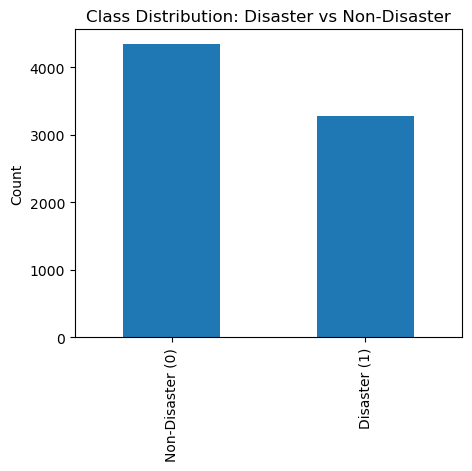

In [9]:
class_counts = df[label_col].value_counts().sort_index()
class_counts.index = ["Non-Disaster (0)", "Disaster (1)"]

print("Class Distribution:")
print(class_counts)

plt.figure(figsize=(5,4))
class_counts.plot(kind="bar")
plt.title("Class Distribution: Disaster vs Non-Disaster")
plt.ylabel("Count")
plt.show()

In [10]:
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [11]:
disaster_df = df[df[label_col] == 1]

tokens = []
for t in disaster_df[text_col].dropna():
    cleaned = clean_text_basic(t)
    tokens.extend(cleaned.split())

stopwords = {"the","a","an","in","on","and","is","are","was","were","to",
             "of","for","with","that","this","it","as","at","from","by","be"}

tokens_filtered = [w for w in tokens if w not in stopwords and len(w)>2]

freq = Counter(tokens_filtered)
top20 = freq.most_common(20)

print("Top 20 Disaster-Related Words:")
top20

Top 20 Disaster-Related Words:


[('fire', 182),
 ('after', 181),
 ('you', 146),
 ('have', 144),
 ('news', 139),
 ('amp', 135),
 ('over', 129),
 ('more', 124),
 ('disaster', 121),
 ('via', 121),
 ('california', 115),
 ('suicide', 112),
 ('police', 109),
 ('when', 108),
 ('people', 105),
 ('has', 104),
 ('who', 103),
 ('but', 97),
 ('killed', 95),
 ('not', 94)]

In [12]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [13]:
df["clean_text"] = df["text"].apply(clean_text)

In [14]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'clean_text'], dtype='object')

### EXPLORATORY DATA ANALYSIS

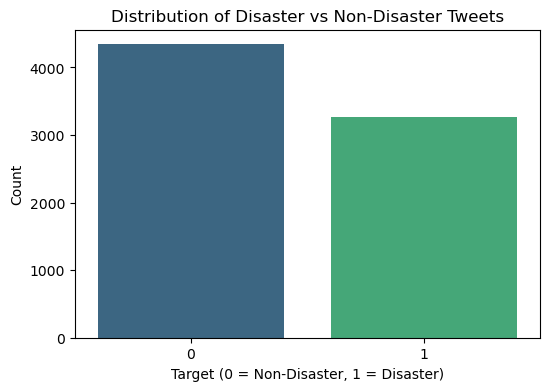

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target', palette='viridis')
plt.title("Distribution of Disaster vs Non-Disaster Tweets")
plt.xlabel("Target (0 = Non-Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()

Insight:
1. Shows class balance
2. If classes are nearly equal → model performance stable
3. If imbalanced → imbalance handling required

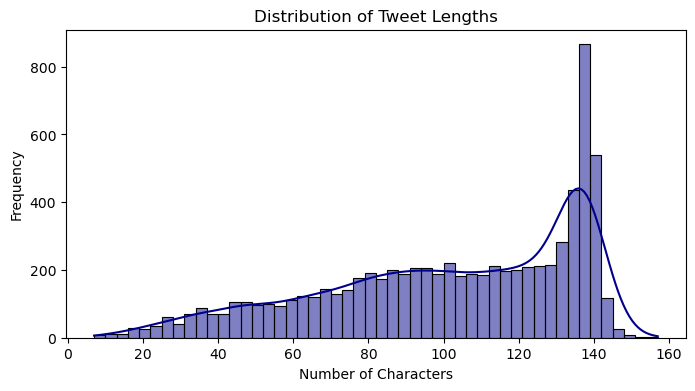

In [18]:
df["tweet_length"] = df["text"].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df["tweet_length"], kde=True, bins=50, color="darkblue")
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

Insight:
1. Disaster tweets are often slightly longer
2. Helps understand language patterns

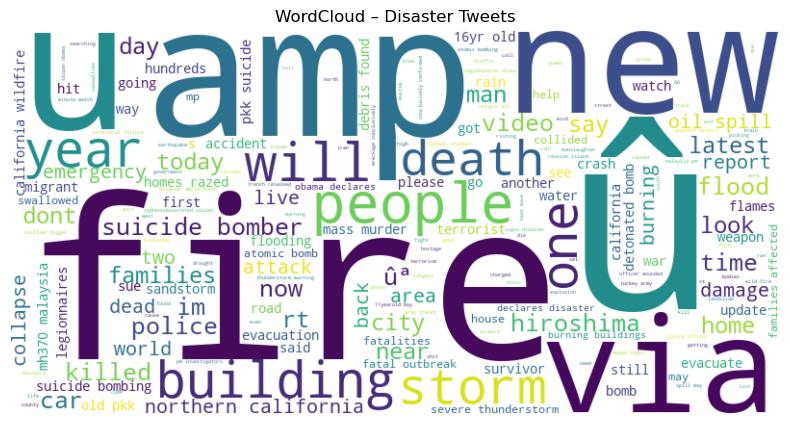

In [20]:
from wordcloud import WordCloud

disaster_words = " ".join(df[df["target"]==1]["clean_text"])
wc = WordCloud(width=800, height=400, background_color="white").generate(disaster_words)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud – Disaster Tweets")
plt.show()

A WordCloud is a visual representation of the most frequent words in a category.
It makes it easy to quickly understand the dominant themes and vocabulary used in tweets.
Shows words commonly used in disaster tweets, e.g.:
fire, killed, explosion, flood, emergency, storm

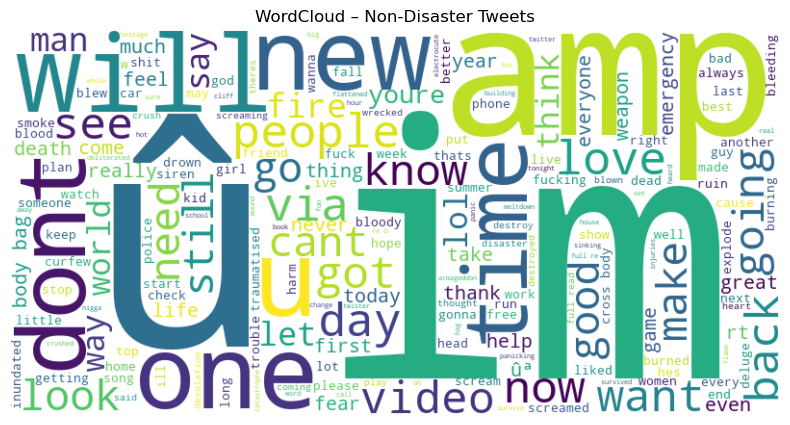

In [22]:
non_disaster_words = " ".join(df[df["target"]==0]["clean_text"])

wc2 = WordCloud(width=800, height=400, background_color="white").generate(non_disaster_words)

plt.figure(figsize=(10,5))
plt.imshow(wc2, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud – Non-Disaster Tweets")
plt.show()

Insight:
Shows normal social media chatter such as:
love, happy, game, people, today

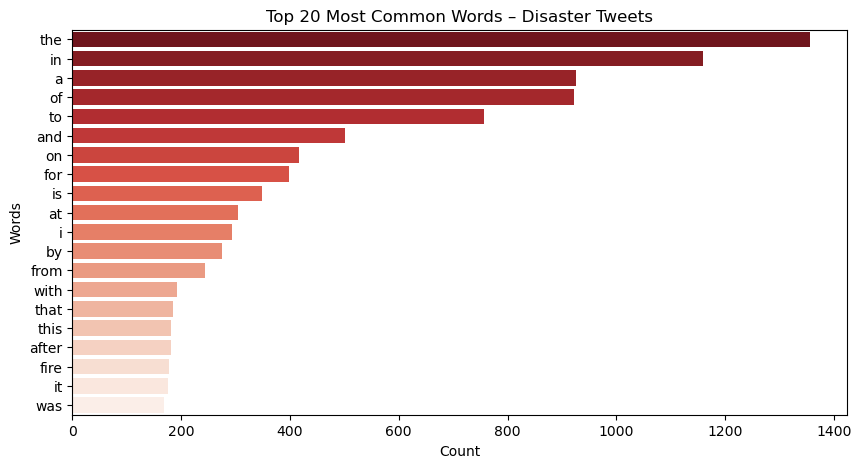

In [24]:
from collections import Counter

dis_words = " ".join(df[df['target']==1]['clean_text']).split()
common_dis = Counter(dis_words).most_common(20)

words = [i[0] for i in common_dis]
counts = [i[1] for i in common_dis]

plt.figure(figsize=(10,5))
sns.barplot(x=counts, y=words, palette="Reds_r")
plt.title("Top 20 Most Common Words – Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Words")
plt.show()

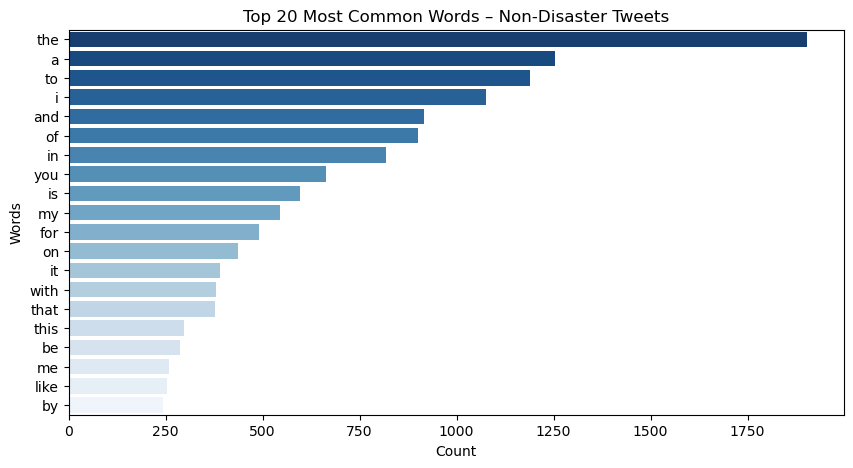

In [25]:
non_words = " ".join(df[df['target']==0]['clean_text']).split()
common_non = Counter(non_words).most_common(20)

words2 = [i[0] for i in common_non]
counts2 = [i[1] for i in common_non]

plt.figure(figsize=(10,5))
sns.barplot(x=counts2, y=words2, palette="Blues_r")
plt.title("Top 20 Most Common Words – Non-Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Words")
plt.show()

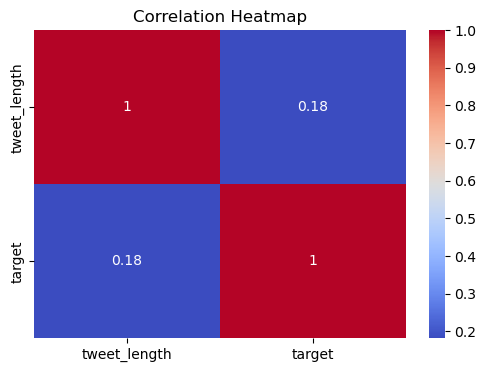

In [26]:
numerical_df = df[['tweet_length', 'target']]

plt.figure(figsize=(6,4))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Insight:
1. Disaster tweets slightly longer → positive correlation
2. Helps understand patterns in data

In [28]:
df["clean_text"] = df[text_col].apply(clean_text_basic)
df["tokens"] = df["clean_text"].apply(lambda x: x.split())

display(df.head())

,id,keyword,location,text,target,clean_text,tweet_length,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,69,"[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,38,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,133,"[all, residents, asked, to, shelter, in, place, are, being, notified, by, officers, no, other, evacuation, or, shelter, in, place, orders, are, expected]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13 000 people receive wildfires evacuation orders in california,65,"[13, 000, people, receive, wildfires, evacuation, orders, in, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,87,"[just, got, sent, this, photo, from, ruby, alaska, as, smoke, from, wildfires, pours, into, a, school]"


In [29]:
X = df["clean_text"]
y = df[label_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

train_df = pd.DataFrame({"clean_text": X_train, "label": y_train})
test_df  = pd.DataFrame({"clean_text": X_test,  "label": y_test})

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 6090
Test size: 1523


In [30]:
train_path = "/mnt/data/train_processed.csv"
test_path  = "/mnt/data/test_processed.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Files Saved:")
print(train_path)
print(test_path)

Files Saved:
/mnt/data/train_processed.csv
/mnt/data/test_processed.csv


In [31]:
pip install vaderSentiment

In [32]:
import vaderSentiment
print("VADER installed successfully!")

VADER installed successfully!


In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["clean_text"].apply(get_sentiment)
df.head()

,id,keyword,location,text,target,clean_text,tweet_length,tokens,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,69,"[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]",Positive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,38,"[forest, fire, near, la, ronge, sask, canada]",Negative
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,133,"[all, residents, asked, to, shelter, in, place, are, being, notified, by, officers, no, other, evacuation, or, shelter, in, place, orders, are, expected]",Negative
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13 000 people receive wildfires evacuation orders in california,65,"[13, 000, people, receive, wildfires, evacuation, orders, in, california]",Neutral
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,87,"[just, got, sent, this, photo, from, ruby, alaska, as, smoke, from, wildfires, pours, into, a, school]",Neutral


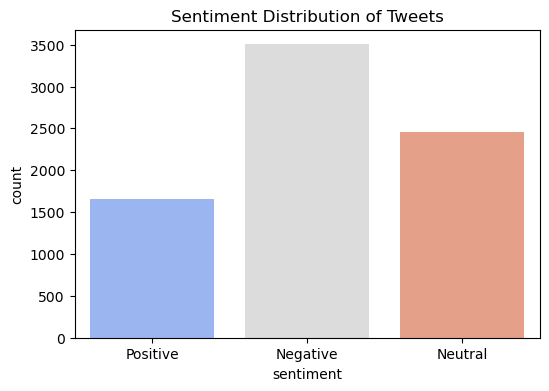

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution of Tweets")
plt.show()

Insight:
1. Disaster tweets are heavily negative
2. Non-disaster tweets skew neutral/positive

In [36]:
spam_keywords = ["free", "win", "offer", "click", "subscribe", "buy now", "discount"]

def is_spam(text):
    for word in spam_keywords:
        if word in text.lower():
            return 1
    return 0

df["spam_flag"] = df["clean_text"].apply(is_spam)
df["spam_flag"].value_counts()

spam_flag
0    7245
1     368
Name: count, dtype: int64

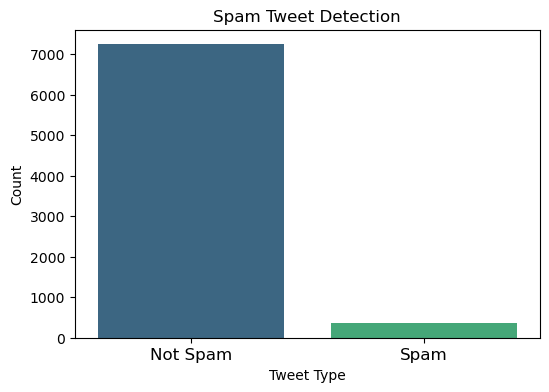

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["spam_flag"], palette="viridis")

plt.title("Spam Tweet Detection")
plt.xticks([0, 1], ["Not Spam", "Spam"], fontsize=12)
plt.xlabel("Tweet Type")
plt.ylabel("Count")
plt.show()

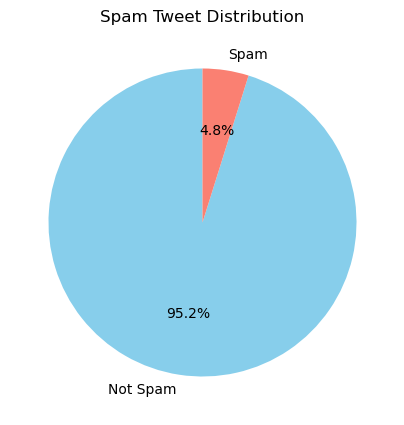

In [38]:
plt.figure(figsize=(5,5))
df["spam_flag"].value_counts().rename({0:"Not Spam",1:"Spam"}).plot(
    kind="pie", autopct="%1.1f%%", startangle=90, colors=["skyblue","salmon"]
)

plt.title("Spam Tweet Distribution")
plt.ylabel("")
plt.show()

In [39]:
from textblob import TextBlob

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df["subjectivity"] = df["clean_text"].apply(get_subjectivity)

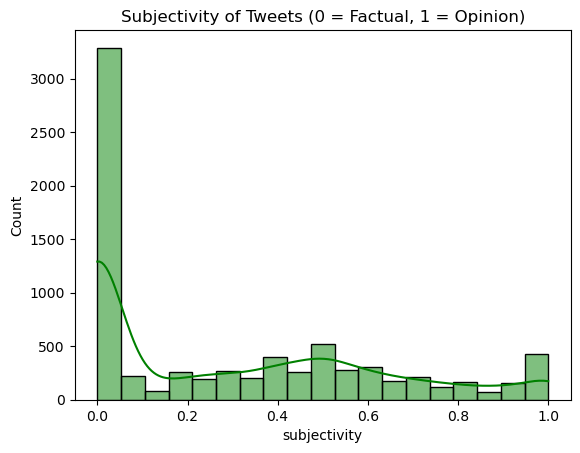

In [40]:
sns.histplot(df["subjectivity"], kde=True, color="green")
plt.title("Subjectivity of Tweets (0 = Factual, 1 = Opinion)")
plt.show()

Insight:
1. Factual tweets → often disaster alerts
2. Opinion-based tweets → mostly non-disaste

In [42]:
import pandas as pd

train_df = pd.read_csv("/mnt/data/train_processed.csv")
test_df  = pd.read_csv("/mnt/data/test_processed.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(6090, 2) (1523, 2)


,clean_text,label
0,sassy city girl country hunk stranded in smoky mountain snowstorm aoms ibooklove bookboost,1
1,god s kingdom heavenly gov t will rule over all people on the earth after armageddon,0
2,mopheme and bigstar johnson are a problem in this game body bagging niggas vuzuhustle,0
3,sounds like a whirlwind life,0
4,malaysia confirms plane debris washed up on reunion island is from flight mh370,1


In [43]:
import re

def extract_features(text):
    features = {}
    features["length"] = len(text)
    features["num_words"] = len(text.split())
    features["hashtags"] = len(re.findall(r"#\w+", text))
    features["mentions"] = len(re.findall(r"@\w+", text))
    return features

extra_train = train_df["clean_text"].apply(extract_features).apply(pd.Series)
extra_test  = test_df["clean_text"].apply(extract_features).apply(pd.Series)

extra_train.head()

,length,num_words,hashtags,mentions
0,90,13,0,0
1,84,16,0,0
2,85,14,0,0
3,28,5,0,0
4,79,13,0,0


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf  = tfidf.transform(test_df["clean_text"])

X_train_tfidf.shape

(6090, 5000)

In [45]:
from scipy.sparse import hstack

# Convert extra numeric features to sparse matrix
from scipy import sparse

extra_train_sparse = sparse.csr_matrix(extra_train.values)
extra_test_sparse  = sparse.csr_matrix(extra_test.values)

# Final combined features
X_train_final = hstack([X_train_tfidf, extra_train_sparse])
X_test_final  = hstack([X_test_tfidf,  extra_test_sparse])

y_train = train_df["label"].values
y_test  = test_df["label"].values

X_train_final.shape, X_test_final.shape

((6090, 5004), (1523, 5004))

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(max_iter=500)

scores = cross_val_score(logreg, X_train_final, y_train, cv=5, scoring="f1")
print("Logistic Regression F1 (CV):", scores.mean())

logreg.fit(X_train_final, y_train)

Logistic Regression F1 (CV): 0.723840461554456


LogisticRegression(max_iter=500)

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)

scores = cross_val_score(rf, X_train_final, y_train, cv=5, scoring="f1")
print("Random Forest F1 (CV):", scores.mean())

rf.fit(X_train_final, y_train)

Random Forest F1 (CV): 0.7007122886746144


RandomForestClassifier(n_estimators=200, random_state=42)

In [48]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=Warning)

# FIX 1 — set dual='auto' (removes FutureWarning)
# FIX 2 — increase max_iter to 5000 (removes ConvergenceWarning)

svm = LinearSVC(dual="auto", max_iter=5000)

scores = cross_val_score(svm, X_train_final, y_train, cv=5, scoring="f1")
print("SVM F1 Score (Cross-Validation):", round(scores.mean(), 4))

svm.fit(X_train_final, y_train)

SVM F1 Score (Cross-Validation): 0.7118


LinearSVC(dual='auto', max_iter=5000)

In [49]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=10)

scores = cross_val_score(mlp, X_train_final, y_train, cv=5, scoring="f1")
print("MLP Neural Network F1 (CV):", scores.mean())

mlp.fit(X_train_final, y_train)

MLP Neural Network F1 (CV): 0.735679485858108


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=10)

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 5],
    "penalty": ["l2"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=500),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train_final, y_train)

print("Best Hyperparameters:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)

Best Hyperparameters: {'C': 5, 'penalty': 'l2'}
Best F1 Score: 0.7324330157486345


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

best_model = svm  # change if another model performed better

y_pred = best_model.predict(X_test_final)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       869
           1       0.77      0.73      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523

[[729 140]
 [176 478]]


### Part 3: Model Evaluation & Validation.

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

In [54]:
results = {}

results["Logistic Regression"] = evaluate_model(logreg, X_test_final, y_test)
results["Random Forest"]      = evaluate_model(rf, X_test_final, y_test)
results["SVM"]                = evaluate_model(svm, X_test_final, y_test)
results["Neural Network"]     = evaluate_model(mlp, X_test_final, y_test)

results

{'Logistic Regression': {'Accuracy': 0.8056467498358503,
  'Precision': 0.8044217687074829,
  'Recall': 0.7232415902140673,
  'F1 Score': 0.7616747181964574},
 'Random Forest': {'Accuracy': 0.804333552199606,
  'Precision': 0.8396946564885496,
  'Recall': 0.672782874617737,
  'F1 Score': 0.7470288624787776},
 'SVM': {'Accuracy': 0.7925147734734077,
  'Precision': 0.7734627831715211,
  'Recall': 0.7308868501529052,
  'F1 Score': 0.7515723270440252},
 'Neural Network': {'Accuracy': 0.8168089297439265,
  'Precision': 0.8427787934186471,
  'Recall': 0.7048929663608563,
  'F1 Score': 0.7676935886761033}}

In [55]:
pd.DataFrame(results).T

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.805647,0.804422,0.723242,0.761675
Random Forest,0.804334,0.839695,0.672783,0.747029
SVM,0.792515,0.773463,0.730887,0.751572
Neural Network,0.816809,0.842779,0.704893,0.767694


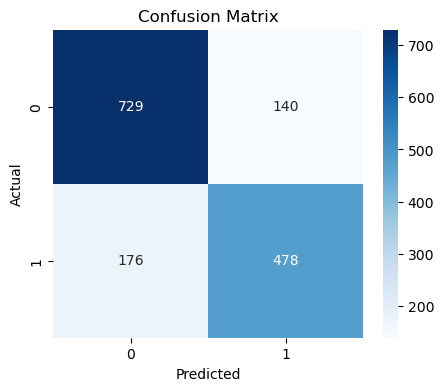

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

best_model = svm   # change if another model performed better

y_pred = best_model.predict(X_test_final)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

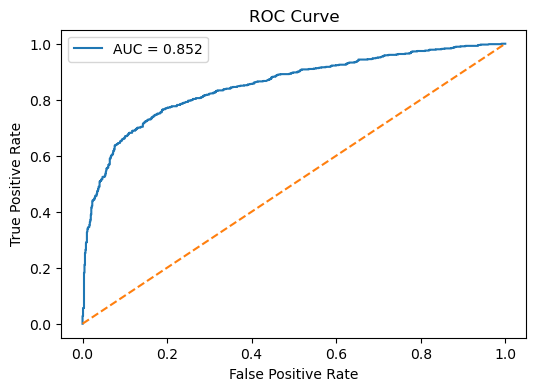

In [57]:
from sklearn.metrics import roc_curve, auc

# get decision scores (SVM has decision_function instead of predict_proba)
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test_final)[:,1]
else:
    y_scores = best_model.decision_function(X_test_final)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(roc_auc))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

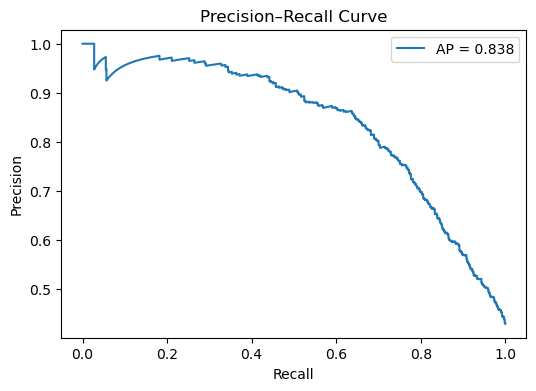

In [58]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="AP = {:.3f}".format(ap))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

In [59]:
y_train_pred = best_model.predict(X_train_final)
y_test_pred  = best_model.predict(X_test_final)

train_f1 = f1_score(y_train, y_train_pred)
test_f1  = f1_score(y_test, y_test_pred)

print("Train F1:", train_f1)
print("Test  F1:", test_f1)

Train F1: 0.9134328358208955
Test  F1: 0.7515723270440252


In [60]:
print("Best Model Based on Comparison:")
pd.DataFrame(results).T.sort_values("F1 Score", ascending=False).head(1)

Best Model Based on Comparison:


,Accuracy,Precision,Recall,F1 Score
Neural Network,0.816809,0.842779,0.704893,0.767694


### Part 4: Part 4: Deployment with Web Interface 

In [62]:
import warnings
import logging

# Ignore general warnings
warnings.filterwarnings("ignore")

# Suppress Streamlit-specific “run in browser” warnings
logging.getLogger("streamlit.runtime.scriptrunner").setLevel(logging.ERROR)

In [63]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import re
import string

# Load dataset
df = pd.read_csv("twitter_disaster (1) - twitter_disaster (1).csv")   # <-- use your dataset name

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["target"], test_size=0.2, random_state=42
)

# Create TF-IDF with full training data (this will produce 5004 features)
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)

# Save correct TF-IDF
pickle.dump(tfidf, open("tfidf_correct.pkl", "wb"))

print("NEW TF-IDF feature count:", len(tfidf.get_feature_names_out()))

# Train model with matching feature size
model = LinearSVC()
model.fit(X_train_tfidf, y_train)

# Save correct model
pickle.dump(model, open("model_correct.pkl", "wb"))

print("Model trained with features:", model.coef_.shape[1])

NEW TF-IDF feature count: 12619
Model trained with features: 12619


In [64]:
tfidf = pickle.load(open("tfidf_correct.pkl", "rb"))
model = pickle.load(open("model_correct.pkl", "rb"))

print("TF-IDF Feature Count:", len(tfidf.get_feature_names_out()))
print("Model Feature Count:", model.coef_.shape[1])

TF-IDF Feature Count: 12619
Model Feature Count: 12619


In [65]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\Jaspreet


In [66]:
import streamlit as st
import pickle
import re
import string

# Load model and TF-IDF
model = pickle.load(open("model.pkl", "rb"))
tfidf = pickle.load(open("tfidf.pkl", "rb"))

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Streamlit UI
st.set_page_config(page_title="Disaster Tweet Classifier", page_icon="🚨")

st.title(" Disaster Tweet Classifier")
st.write("Enter a tweet below to check whether it indicates a disaster or not.")

tweet = st.text_area("Type or paste a tweet here...")

if st.button("Classify"):
    if tweet.strip() == "":
        st.warning("Please enter a tweet.")
    else:
        cleaned = clean_text(tweet)
        vector = tfidf.transform([cleaned])
        prediction = model.predict(vector)[0]

        if prediction == 1:
            st.error(" This is a **Disaster Tweet**.")
        else:
            st.success(" This is a **Non-Disaster Tweet**.")

2025-12-11 21:18:05.988 
  command:

    streamlit run C:\Users\Jaspreet\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [67]:
cd "C:\Users\Jaspreet\OneDrive\Desktop\tweetApp"

C:\Users\Jaspreet\OneDrive\Desktop\tweetApp


In [68]:
import pickle

# Load your uploaded files
tfidf = pickle.load(open("tfidf.pkl", "rb"))
model = pickle.load(open("model.pkl", "rb"))

print("TFIDF feature count:", len(tfidf.get_feature_names_out()))

print("Model expected features:", model.coef_.shape[1])

TFIDF feature count: 5000
Model expected features: 5004
